# Download Data

In [1]:
!pip install -q kaggle

Kode diatas digunakan untuk menginstall package kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"taqiyyaghazi","key":"3d683ab205492333dc881ebc51c129bc"}'}

Kode diatas digunakna untuk mengupload file api key Kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Kode diatas digunakan untuk membuat membuat direktori .kaggle untuk menyimpan kredensial API Kaggle dan menyalin file kaggle.json ke dalamnya untuk autentikasi.

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

Kode diatas digunakan untuk mengatur izin file kaggle.json di direktori .kaggle agar hanya pemiliknya yang dapat membaca dan menulis, menjaga keamanan kredensial API Kaggle.

In [5]:
!kaggle datasets download hsankesara/medium-articles

Dataset URL: https://www.kaggle.com/datasets/hsankesara/medium-articles
License(s): CC0-1.0
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 156MB/s]


Kode diatas digunakan untuk mengundug dataset dari Hsankesara dengan nama Medium Articles

In [6]:
!unzip medium-articles.zip

Archive:  medium-articles.zip
  inflating: articles.csv            


Kode diatas digunakan untuk mengekstrak file medium-articles.zip ke dalam direktori saat ini, sehingga isi file dapat diakses dan digunakan.

# Import Data

In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import FastText
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Kode ini mengimpor pustaka yang diperlukan untuk memproses teks dan membangun sistem rekomendasi berbasis konten. Berikut adalah penjelasan singkat tentang masing-masing pustaka:

* **pandas**: Digunakan untuk memanipulasi data dalam bentuk DataFrame.
* **re**: Pustaka ekspresi reguler yang digunakan untuk manipulasi teks, seperti menghapus tanda baca.
* **nltk**: Pustaka pemrosesan bahasa alami yang menyediakan alat untuk stop words dan lemmatization.
* **stopwords**: Sub-pustaka dari NLTK untuk menghapus kata-kata umum yang tidak memiliki makna penting (misalnya, "and", "the").
* **WordNetLemmatizer**: Digunakan untuk mengubah kata menjadi bentuk dasarnya (lemmatization).
* **FastText**: Model pembelajaran mesin untuk mendapatkan representasi teks dalam bentuk vektor.
* **numpy**: Pustaka untuk komputasi numerik yang digunakan untuk manipulasi array dan operasi matematika.
* **cosine_similarity**: Digunakan untuk menghitung kemiripan kosinus antara vektor artikel, yang merupakan dasar dari sistem rekomendasi berbasis konten.

Selain itu, kode ini juga mengunduh daftar stop words dan kamus WordNet yang diperlukan untuk lemmatization.

In [8]:
df = pd.read_csv('/content/articles.csv')
df.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


Kode ini membaca file CSV bernama articles.csv yang berada di direktori /content/ dan memuatnya ke dalam DataFrame df menggunakan pustaka pandas. Setelah memuat data, perintah df.head() akan menampilkan lima baris pertama dari DataFrame tersebut untuk memberikan gambaran tentang struktur dan isi data. Terlihat bahwa data tersebut memiliki 6 kolom yaitu author, claps, reading_time, link, title, dan text.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        337 non-null    object
 1   claps         337 non-null    object
 2   reading_time  337 non-null    int64 
 3   link          337 non-null    object
 4   title         337 non-null    object
 5   text          337 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.9+ KB


Dari informasi diatas dapat diketahui bahwa dataset berjumlah 337 artikel dengan tidak ada nilai yang bernilai null

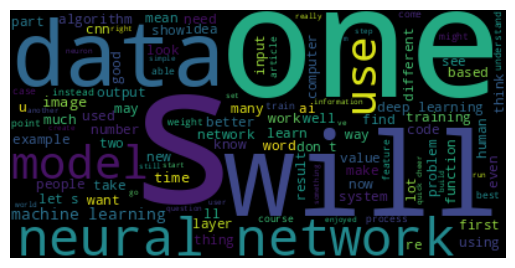

In [10]:
text = ' '.join([item for item in df.text]).lower()

wordcloud = WordCloud(stopwords=set(STOPWORDS)).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Berdasarkan word cloud diatas dapat diketahui bahwa mayoritas artikel membahas tentang Data, model, neural network

# Data Preparation

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['processed_article'] = df['text'].apply(preprocess_text)

Kode ini mendefinisikan sebuah fungsi preprocess_text yang digunakan untuk melakukan praproses teks pada kolom Article dalam DataFrame df. Berikut adalah langkah-langkah yang dilakukan oleh fungsi ini:

1. Lowercasing: Mengubah seluruh teks menjadi huruf kecil untuk konsistensi.
2. Menghapus Tanda Baca: Menggunakan ekspresi reguler (re.sub) untuk menghapus semua karakter yang bukan huruf atau spasi.
3. Tokenisasi: Memecah teks menjadi daftar kata-kata (tokens).
4. Menghapus Stop Words: Menghilangkan kata-kata umum yang tidak penting menggunakan daftar stop words dari NLTK.
5. Lemmatization: Mengubah setiap kata ke bentuk dasar (lemma) menggunakan WordNetLemmatizer.
6. Menggabungkan Kembali: Menggabungkan kembali daftar kata yang sudah diproses menjadi satu string.

Setelah fungsi didefinisikan, kode ini menerapkannya pada kolom Article di DataFrame df, menyimpan hasil praproses di kolom baru bernama processed_article.

In [12]:
sentences = [article.split() for article in df['processed_article']]

Kode ini mengubah setiap artikel yang telah diproses menjadi daftar kata (tokens) dengan memisahkannya berdasarkan spasi. Hasilnya adalah daftar daftar kata (sentences), di mana setiap daftar mewakili satu artikel.

In [13]:
model = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

* **sentences**: Daftar kalimat yang akan digunakan untuk melatih model FastText.
* **vector_size=100**: Menentukan dimensi vektor embedding (representasi vektor untuk setiap kata) yang akan dihasilkan oleh model.
* **window=5**: Ukuran jendela konteks di sekitar kata target yang akan dipertimbangkan oleh model saat melatih embedding.
* **min_count=1**: Kata-kata yang muncul setidaknya satu kali dalam corpus akan dipertimbangkan untuk pelatihan (tidak ada kata yang diabaikan berdasarkan frekuensi kemunculan).
* **workers=4**: Jumlah thread yang akan digunakan untuk pelatihan paralel.
* **sg=1**: Menggunakan model Skip-Gram (sg=1), yang memprediksi konteks kata berdasarkan kata target.

In [14]:
def get_article_vector(article, model):
    words = article.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['article_vector'] = df['processed_article'].apply(lambda x: get_article_vector(x, model))

Fungsi get_article_vector digunakan untuk menkonversi setiap kata dalam article kedalam vector menggunakan model yang telah dilatih. Kemudian fungsi tersebut diimplementasikan ke data artikel yang telah diproses dan disimpan pada koloom article_vector.

In [24]:
def convert_claps_to_numeric(claps_str):
    if 'K' in claps_str:
        return float(claps_str.replace('K', '').replace(',', '').strip()) * 1000
    elif 'M' in claps_str:
        return float(claps_str.replace('M', '').replace(',', '').strip()) * 1000000
    else:
        return float(claps_str.replace(',', '').strip())

Fungsi convert_claps_to_numeric mengubah nilai jumlah "claps" dari format string yang menggunakan satuan ribuan (K) atau juta (M) menjadi angka numerik yang sesuai. Jika string mengandung 'K', fungsi ini menghapus 'K' dan mengalikan nilai numerik dengan 1000. Jika mengandung 'M', fungsi ini menghapus 'M' dan mengalikan nilai numerik dengan 1.000.000. Jika tidak ada satuan, fungsi hanya menghapus koma dan mengonversi string ke float.

In [25]:
df['claps_numeric'] = df['claps'].apply(convert_claps_to_numeric)

Perintah ini mengonversi nilai dalam kolom claps dari format string ke format numerik menggunakan fungsi convert_claps_to_numeric dan menyimpan hasilnya di kolom baru claps_numeric pada DataFrame df. Kolom ini akan digunakan untuk menghitung metrik evaluasi.

# Model Development dengan Content Based Filtering

In [28]:
def recommend_articles(title, data, model, top_n=5):
    article_vector = df.loc[df['title'] == title, 'article_vector'].values[0]
    df['similarity'] = df['article_vector'].apply(lambda x: cosine_similarity([article_vector], [x]).flatten()[0])
    recommendations = df.sort_values('similarity', ascending=False).head(top_n + 1)
    return recommendations[['title', 'similarity']].iloc[1:]

Fungsi recommend_articles digunakan untuk merekomendasikan artikel-artikel yang mirip dengan artikel tertentu berdasarkan vektor representasi yang telah dihitung. Berikut adalah penjelasan langkah-langkah fungsinya:
* Mencari vektor representasi artikel dengan judul yang diberikan (title) dari kolom article_vector dalam DataFrame df.
* Menghitung kesamaan kosinus antara vektor artikel target dan vektor setiap artikel lain di DataFrame. Hasilnya disimpan di kolom baru similarity, yang menunjukkan sejauh mana setiap artikel mirip dengan artikel target.
* Mengurutkan DataFrame berdasarkan kolom similarity secara menurun, sehingga artikel yang paling mirip dengan artikel target muncul di atas. Memilih top_n + 1 artikel teratas (ditambah satu untuk mengecualikan artikel target itu sendiri).
* Mengembalikan kolom Title dan similarity dari artikel-artikel yang direkomendasikan. iloc[1:] digunakan untuk mengabaikan artikel target itu sendiri dalam daftar rekomendasi.

In [19]:
read_article = df.title[1]
read_article

'Python for Data Science: 8 Concepts You May Have Forgotten'

Kode diatas mensimulasikan salah satu artikel yang telah dibaca user.

In [20]:
recommendations = recommend_articles(read_article, df, model)
print(recommendations)

                                                 title             author  \
44   Machine Learning Exercises In Python, Part 1 –...    John Wittenauer   
303                    Taking Keras to the Zoo – Gab41            Karl N.   
305  CrAIg: Using Neural Networks to learn Mario – ...      Nikolai Savas   
192  Ultimate Guide to Leveraging NLP & Machine Lea...  Stefan Kojouharov   
332  You can build a neural network in JavaScript e...     Daniel Simmons   

     similarity  
44     0.995488  
303    0.995384  
305    0.993123  
192    0.992181  
332    0.992052  


Kode diatas digunakan untuk mendapatkan artikel rekomendasi dari artikel yang telah dibaca user. Didapatkan 5 artikel yang direkomendasikan adalah seperti yang ditampilkan diatas.

# Evaluation

In [52]:
def evaluate_model(df, model, relevant_threshold=50, top_n=10):
    precision_list = []
    recall_list = []

    for index, row in df.iterrows():
        input_title = row['title']


        relevant_articles = df[df['claps_numeric'] > relevant_threshold]
        recommended_articles = recommend_articles(input_title, df, model, top_n=top_n)
        true_positives = recommended_articles[recommended_articles['title'].isin(relevant_articles['title'])]
        precision = len(true_positives) / len(recommended_articles) if len(recommended_articles) > 0 else 0
        recall = len(true_positives) / len(relevant_articles) if len(relevant_articles) > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)

    average_precision = sum(precision_list) / len(precision_list)
    average_recall = sum(recall_list) / len(recall_list)

    return average_precision, average_recall

average_precision, average_recall = evaluate_model(df, model)

print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')


Average Precision: 0.8350148367952525
Average Recall: 0.030699074882178466


Fungsi evaluate_model menghitung precision dan recall rata-rata dari sistem rekomendasi dengan mengiterasi setiap artikel dalam DataFrame df. Untuk setiap artikel, fungsi ini:

Mengidentifikasi artikel relevan berdasarkan relevant_threshold.
Mengambil rekomendasi artikel dengan recommend_articles.
Menghitung precision dan recall berdasarkan artikel relevan dan rekomendasi.
Menyimpan hasil precision dan recall.
Hasil akhir adalah rata-rata precision dan recall dari seluruh artikel, yang dicetak di akhir.